# RegularizationAndDropout(Application)

如果模型过拟合,即:

(1) 训练样本正确率远大于验证/测试样本正确率.

(2) 验证/测试样本损失升高.

那么我们可以采用Regulariztion,Dropout,early stopping等.

**Note:**

(1) 除非模型过拟合,否则无需使用以上方法

(2) 在解决过拟合的过程中,无论是训练集,验证/测试集的正确率一般都会下降,这是取舍问题.

(3) 即使使用以上方法处理过拟合,但是如果某些超级参数(学习率,迭代次数)等调整的不好,模型会先减少过拟合,之后又会继续过拟合.也就是说,如果调整不好,模型依然会过拟合.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import scipy.io
from Plot_Plot import plot_plot
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

### Load Data

为了直观理解过拟合,以及解决过拟合,我们采用以下简单数据,并且使得整体模型处于过拟合的状态,然后再来对比各种方法.

In [2]:
def load_2D_dataset():
    '''
    load dataset
    '''
    data = scipy.io.loadmat('../../data_set/data.mat')
    train_X = data['X']
    train_Y = np.squeeze(data['y'])
    test_X = data['Xval']
    test_Y = np.squeeze(data['yval'])

    plt.scatter(train_X[:,0], train_X[:,1], c=train_Y.ravel(), s=40, cmap=plt.cm.Spectral);
    
    return train_X, train_Y, test_X, test_Y

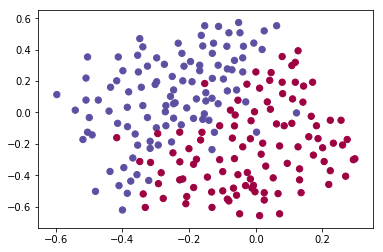

In [3]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

### 1.No-Regularization

首先先来看看没有使用正则化的模型```class BL_Model```.

**Note:**

我们会了使用regularization,所以我们会人为的将模型过拟合.

**函数解释表:**

[1] 

```python
def __init__(self,layers,epochs,lr,print_step=100,is_print=False):
    ...```
    
该函数主要作用就是初始化一些参数,比如学习率:```lr```,网络结构:```layers```,迭代次数:```epochs```等.


[2]

```python

def init_parameters(self):
    ...```
    
初始化weights:$W$,bias:$b$,shape:```W:[input_features,output_features]```,```b:[1,output_features]```

[3]

```python
def forward(self,X,parameters):
    ...```
    
Forward Propagation,hidden layers 使用Relu,output layers 使用sigmoid.

[4]

```python
def backward(self,A,y,parameters,cache):
    ...```
    
Backward Propagation,输出$dW,db$.函数中的$dA$只是缓存作用,用于计算$dZ$.

[5]

```python

def update(self,parameters,dparameters):
    ...```

Updating $W,b$.

[6]

```python
def fit(self,data,labels,val_data,val_labels):
    ...```

训练模型,由于我们的shape:$y=(m_sample,)$的形式,我们需要做处理,转换成$y=(m_sample,1)$的形式,否则会因为$A=(m_sample,1)$,$y=(m_sample,)$,Numpy会广播错形状,倒是出现$(m_sample,m_sample)$的形式.


[7]

```python
def score(self,X,y,parameters,is_loss=False):
    ...```
    
评分函数,用于处理在迭代过程中训练集和测试集的正确率以及测试集的误差.

[8]

```python
def plot_decision_boundary(self,X,Y,paramerters,title):
    ...```

绘制决策边界.

找到每一个特征的最大值与最小值,编织网格(也就是获得该范围内的所有点),将这些所有点进行预测,绘制出决策边界.


In [56]:
class BL_Model:
    """
    Build Base Model.
    """
    def __init__(self,layers,epochs,lr,print_step=100,is_print=False):
        """
        Initialization class
        
        Parameters:
        ----------
            layers: hidden layer's units,like [2,3,1],2: first hidden layer,3:second hidden layer 1:output layer.
            epochs: #Iterate 
            lr: Learning rate.
            print_step: print loss step.
            is_print: is print is ture,else not print loss.
        """
        self.layers = layers
        self.epochs = epochs
        self.print_step = print_step
        self.lr = lr
        self.is_print = is_print
        # using cache cost,train accuracy, validation accuracy.
        self.costs = []
        self.acc_trains = []
        self.val_costs = []
        self.acc_vals = []
    
    def init_parameters(self):
        """
        Initialization parameters.
        
        init weights and bias:
            weights shape: [input_features,output_features]
            bais shape: [1,output_features]
        """
        np.random.seed(3)
        self.L = len(self.layers)
        parameters = {}
        for l in range(self.L-1):
            W = np.random.randn(self.layers[l],self.layers[l+1]) / np.sqrt(self.layers[l])
            b = np.zeros((1,self.layers[l+1]))
            parameters['W' + str(l+1)] = W
            parameters['b' + str(l+1)] = b
            
        return parameters
    
    def relu(self,Z):
        """
        activation function ReLu.
        """
        return np.maximum(0,Z)
    def sigmoid(self,Z):
        """
        activation function sigmoid.
        """
        return 1./(1.+np.exp(-Z))
    
    def loss(self,A,y):
        """
        caculate loss.
        Parameters:
        ----------
            A: output layers value.
            y: true labels. shape must be [m_sample/batch size,1].
            
        Return:
        ------
            J: loss value
        """
        m = y.shape[0]
        J = -np.sum(np.add(np.multiply(y,np.log(A)),np.multiply((1-y),np.log(1-A))))/m
        return J
    
    
    def forward(self,X,parameters):
        """
        Forward Propagation.
        Parameters:
        ----------
            X: data set.
            parameters: include weights and bias.
        Returns:
        -------
            A: output layer value.
            cache: include Z and A. using for backward propagation.
        """
        A = X
        cache = {'A0':A}
        for l in range(self.L-1):
            W = parameters['W' + str(l+1)]
            b = parameters['b' + str(l+1)]
            Z = np.dot(A,W) + b
            cache['Z'+str(l+1)] = Z
            if l != self.L-2:
                A = self.relu(Z)
            else:
                A = self.sigmoid(Z)
            cache['A'+str(l+1)] = A
        return A,cache
    
    def backward(self,A,y,parameters,cache):
        """
        Backward Propagation.
        
        Parameters:
        ----------
            A: output layer value.
            y: true labels. shape must be [m_sample/batch size,1].
            parameters: include weights and bias.
            cache: include Z and A.
        Returns:
        -------
            d_parameters: include dW,db,dA,using for updating.
        """
        m = y.shape[0]
        d_parameters ={}
        
        for l in range(self.L-1,0,-1):
            if l == self.L-1:
                d_parameters['dZ'+str(l)] = np.subtract(cache['A'+str(l)],y)
                assert d_parameters['dZ'+str(l)].shape == cache['Z'+str(l)].shape
            else:
                d_parameters['dZ'+str(l)] = np.multiply(d_parameters['dA'+str(l)],np.int64(cache['Z'+str(l)] > 0))

            d_parameters['dW'+str(l)] = np.dot(cache['A'+str(l-1)].T,d_parameters['dZ'+str(l)])/m 
            d_parameters['db'+str(l)] = np.sum(d_parameters['dZ'+str(l)],axis=0,keepdims=True)/m
            
            if l !=1:
                
                d_parameters['dA'+str(l-1)] = np.dot(d_parameters['dZ'+str(l)],parameters['W'+str(l)].T)

        return d_parameters
    
    def update(self,parameters,dparameters):
        """
        Update parameters.
        
        Parameters:
        ----------
           parameters: include weights and bias.
           dparameters : include derivative weights and derivative bias.
           
        Return:
        ------
            parameters: updated parameters.
        """
        for l in range(self.L-1):
            parameters['W'+str(l+1)] -=  self.lr * dparameters['dW'+str(l+1)]
            parameters['b'+str(l+1)] -=  self.lr * dparameters['db'+str(l+1)]
        return parameters
    
    
    def fit(self,data,labels,val_data,val_labels):
        """
        Fitting Model.
        
        ##################################################################################################
        # 1.reshape train/val labels, shape like [m_sample,1].                                           #
        # 2.add inpute layer features to layers,so layers like [input units,hidden units,output units].  #
        # 3.Initialization parameters.                                                                   #  
        # 4. start training model.                                                                       #      
        # 5. each sel.print_step to print loss and add accuracy/ val loss.                               #
        # 6. returns something.                                                                          #
        ##################################################################################################
        
        Parameters:
        ----------
            data: training data set.
            labels: training labels.
            val_data: validation data set.
            val_labels: validation labels.
        Returns:
        -------
            self.costs: loss value of each self.print.
            self.acc_trains: training data accuracy of each self.print.
            self.acc_vals: validation accuracy of each self.print.
            self.val_costs: validation loss value of each self.print.
        """
        labels = labels.reshape(-1,1)
        val_labels = val_labels.reshape(-1,1)
        m,n = data.shape
        self.layers.insert(0,n)
        print("layers",self.layers)
        self.L = len(self.layers)
        parameters = self.init_parameters()
        seed = 0
        
        # start training.
        for epoch in range(self.epochs):
            # start forward
            A,cache = self.forward(X=data,parameters=parameters)
            # start calculate loss
            loss = self.loss(A,labels)
            # start backward
            d_parameters = self.backward(A=A,y=labels,parameters=parameters,cache=cache)
            # start updated
            parameters = self.update(parameters=parameters,dparameters=d_parameters)
                
            if epoch % self.print_step ==0 and self.is_print:
                acc_train = self.score(data,labels,parameters)
                acc_val,val_loss = self.score(val_data,val_labels,parameters,is_loss=True)
                print('[{}/{}] train loss:{} - train acc:{} - val loss:{} - val acc:{}'.format(epoch+self.print_step,
                                                                                              self.epochs,
                                                                                              loss,
                                                                                              acc_train,
                                                                                              val_loss,
                                                                                              acc_val))
                self.costs.append(loss)
                self.acc_trains.append(acc_train)
                self.acc_vals.append(acc_val)
                self.val_costs.append(val_loss)
                
        return self.costs,self.acc_trains,self.acc_vals,self.val_costs,parameters
        
            
    def score(self,X,y,parameters,is_loss=False):
        """
        Score model.
        Parameters:
        ----------
            X: score data set.
            y: score data labels.
            parameters:include best weigts and bias.
            is_loss:  calculate X's loss if ture,generally calculate validation data loss.
        Returns:
        -------
            acc: correct rate.
            loss: loss value if caculate.
        """
        m = y.shape[0]
        A,_ = self.forward(X=X,parameters=parameters)
        predict = np.round(A)
        
        acc = (np.equal(predict,y)).sum() / m
        if is_loss:
            loss = self.loss(A,y)
            return acc,loss    
        else:
            return acc
        
    def plot_decision_boundary(self,X,Y,paramerters,title):
        """
        Plot decision boundary.
        
        Parameters:
        ----------
            X: data set.
            Y: data labels.
            paramerters: best parameters.
            title: figure title.
        """
        
        # get minimum value and maximum value
        x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
        y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1

        # get all value in minimum value and maximum value.
        x = np.arange(x_min,x_max,0.01)
        y = np.arange(y_min,y_max,0.01)
        xx,yy = np.meshgrid(x,y) # meshgrid

        X_ = np.c_[xx.ravel(),yy.ravel()] # ravel value and splice(columns). shape like [m_sample,features]
        
        A,_ = self.forward(X=X_,parameters=paramerters)
        y_hat = np.round(A)
        
        fig = plt.figure()
        plt.subplot(1,1,1)
        plt.xlim([-0.75,0.40])  # Set the x-axis range
        plt.ylim([-0.75,0.65])
        plt.title('model with {} initialization'.format(title))
        plt.scatter(X_[:,0], X_[:,1], c=np.squeeze(y_hat))
        plt.scatter(X[:,0], X[:,1], c=np.squeeze(Y), cmap=plt.cm.Spectral,linewidths=1)

### Running Base Lines Model

In [57]:
layers = [20,3,1]
bl_model = BL_Model(layers=layers,epochs=35000,lr=0.3,print_step=3500,is_print=True)
costs_bl,acc_trains_bl,acc_vals_bl,val_costs_bl,parameters_bl = bl_model.fit(train_X,train_Y,test_X,test_Y)

layers [2, 20, 3, 1]
[3500/35000] train loss:0.7069333662044472 - train acc:0.17061611374407584 - val loss:0.6978600924282838 - val acc:0.125
[7000/35000] train loss:0.19457846053775377 - train acc:0.9241706161137441 - val loss:0.21461855531839055 - val acc:0.94
[10500/35000] train loss:0.19097240175027316 - train acc:0.9241706161137441 - val loss:0.22653005109646138 - val acc:0.94
[14000/35000] train loss:0.1750658888881251 - train acc:0.9383886255924171 - val loss:0.23225810962295954 - val acc:0.96
[17500/35000] train loss:0.1731997169299871 - train acc:0.933649289099526 - val loss:0.24551692224741303 - val acc:0.96
[21000/35000] train loss:0.17135869095102066 - train acc:0.933649289099526 - val loss:0.2540861701974712 - val acc:0.96
[24500/35000] train loss:0.17076395947820708 - train acc:0.933649289099526 - val loss:0.2598926275735973 - val acc:0.96
[28000/35000] train loss:0.169829579108608 - train acc:0.933649289099526 - val loss:0.2667380711952089 - val acc:0.96
[31500/35000] tr

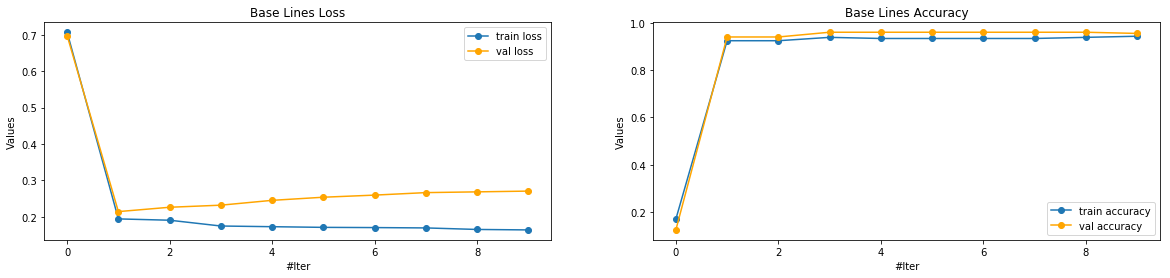

In [47]:
plot_plot(costs=costs_bl,acc_trains=acc_trains_bl,acc_vals=acc_vals_bl,val_costs=val_costs_bl,method='Base Lines')

可以看出在大约3个epoch的时候,validation loss 开始上升,模型开始过拟合.当然这是我们人为的.

接着我们看看决策边界绘制出来的情况.

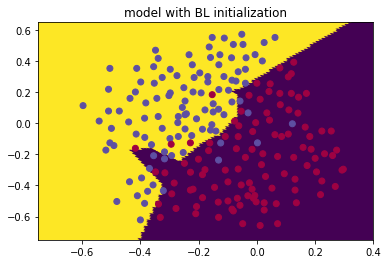

In [48]:
bl_model.plot_decision_boundary(X=train_X,Y=train_Y,paramerters=parameters_bl,title='BL')

很明显,可以看出过拟合.那么下面我们将尝试以下方法解决模型过拟合.

(1) Regulation:

(1.1) L1

(1.2) L2

(2) Dropout 


-----------

### 2.Regulation:

**L1 regularization:**

$||x||_1 :=\sum_{i=1}^{n}|x_i|^{1}$

那么损失函数加入L1正则化以后的形式为:

$J(w,b) = \frac{1}{m}\cdot \sum_{i=1}^{m}(L( \hat{y}_{i},y_{i})) + \frac{\lambda}{m} \sum_{l=1}^{L}|w_l|^{1}_1$

其中$\lambda$为超级参数,需要自己调控来控制稀疏程度,等于0的时候代表不稀疏化.

这里除上$m$是为了标量化一下.

那么根据链式法则,$W$的反向传播方式有所改变:

对于初始化$W$权重方式采用```[input_features,output_features]```

则:

$dW^{[l]}=\frac{(dA^{[l-1]}\cdot dZ^{[l]} + \lambda \cdot sign(W^{[l]}))}{m}$



当然,也可以直接在更新$W$的时候使用:

$W^{[l]} = W^{[l]} - \alpha\cdot (dW^{[l]} + \frac{\lambda \cdot sign(W^{[l]}))}{m})$

两者是等价的.

---------------

**L2 regularization:**

$||x||_2 :=(\sum_{i=1}^{n}|x_i|^{2})^{\frac{1}{2}}$

那么损失函数加入L2正则化以后的形式为:

$J(w,b) = \frac{1}{m}\cdot \sum_{i=1}^{m}(L( \hat{y}_{i},y_{i})) + \frac{\lambda}{2m} \sum_{l=1}^{L}|w_l|^{2}_2$

其中$\lambda$为超级参数,需要自己调控来控制稀疏程度,等于0的时候代表不稀疏化.

这里除上$2m$是为了求导数时能够将2给消除,$m$是做一下标量化.

那么根据链式法则,$W$的反向传播方式有所改变:

对于初始化$W$权重方式采用```[input_features,output_features]```

则:

$dW^{[l]}=\frac{(dA^{[l-1]}\cdot dZ^{[l]} + \lambda \cdot W^{[l]})}{m}$



当然,也可以直接在更新$W$的时候使用:

$W^{[l]} = W^{[l]} - \alpha\cdot (dW^{[l]} + \frac{\lambda \cdot W^{[l]})}{m})$

两者是等价的.

<p style="color:orange">实际上$L_2$范数会比$L_1$范数更加实用,因为$L_2$只是做衰减(decay),只会将$w_i$尽量向0靠近,减少权重,而$L_1$比较猛,直接就是向0使劲靠.</p>

**函数解释表:**

对于Regularization来说,与Base Lines不同的是计算loss与反向传播或者更新方式,这里选择的是反向传播.

[1] 

```python
def loss(self,A,y,parameters):
    ...```
    
计算loss的时候,我们需要判断是走"L1"还是"L2".

计算"L1"或者"L2"来说我们使用计算图的方式:

"L1":

```python

J = -np.sum(np.add(np.multiply(y,np.log(A)),np.multiply((1-y),np.log(1-A))))
            abs_sum_W = np.sum([np.sum(np.abs(value)) for key,value in parameters.items() if 'W' in key])
            L1_J = (J + self.lambd * abs_sum_W) / m```
其中```np.sum([np.sum(np.abs(value)) for key,value in parameters.items() if 'W' in key])```是计算所有隐藏层$W$的绝对值和.

相当于:$\sum_{l=1}^{L}|w_l|^{1}_1$

"L2":

```python
J = -np.sum(np.add(np.multiply(y,np.log(A)),np.multiply((1-y),np.log(1-A))))
            abs_sum_W = np.sum([np.sum(np.square(value)) for key,value in parameters.items() if 'W' in key])
            L2_J = (J + (self.lambd * abs_sum_W)/2)/ m
            return L2_J```
     
其中```np.sum([np.sum(np.square(value)) for key,value in parameters.items() if 'W' in key])```是计算所有隐藏层$W$的平方和.

相当于:$\sum_{l=1}^{L}|w_i|^{2}_2$

[2]

```python
def backward(self,A,y,parameters,cache):
    ...```
    
计算$dW$采用计算图的方式:

"L1:"

```python
dW_part1 = np.dot(cache['A'+str(l-1)].T,d_parameters['dZ'+str(l)])
                dW_part2 = self.lambd * np.sign(parameters['W'+str(l)])
                d_parameters['dW'+str(l)] = (dW_part1 + dW_part2)/m ```

其中```self.lambd * np.sign(parameters['W'+str(l)])```相当于$\lambda \cdot sign(W^{[l]}))$

"L2:"

```python
dW_part1 = np.dot(cache['A'+str(l-1)].T,d_parameters['dZ'+str(l)])
                dW_part2 = self.lambd * parameters['W'+str(l)]
                d_parameters['dW'+str(l)] = (dW_part1 + dW_part2)/m```
               
其中```self.lambd * parameters['W'+str(l)]```相当于$\lambda \cdot W^{[l]}$.


In [13]:
class Regular_Model:
    """
    Regularization Model
    """
    def __init__(self,layers,epochs,lr,print_step=100,is_print=False):
        """
        Initialization class
        
        Parameters:
        ----------
            layers: hidden layer's units,like [2,3,1],2: first hidden layer,3:second hidden layer 1:output layer.
            epochs: #Iterate 
            lr: Learning rate.
            print_step: print loss step.
            is_print: is print is ture,else not print loss.
        """
        self.layers = layers
        self.epochs = epochs
        self.print_step = print_step
        self.lr = lr
        self.is_print = is_print
        self.costs = []
        self.acc_trains = []
        self.val_costs = []
        self.acc_vals = []
    
    def init_parameters(self):
        """
        Initialization parameters.
        
        init weights and bias:
            weights shape: [input_features,output_features]
            bais shape: [1,output_features]
        """
        np.random.seed(1)
        self.L = len(self.layers)
        
        parameters = {}
        for l in range(self.L-1):
            W = np.random.randn(self.layers[l],self.layers[l+1]) / np.sqrt(self.layers[l])
            b = np.zeros((1,self.layers[l+1]))
            parameters['W' + str(l+1)] = W
            parameters['b' + str(l+1)] = b
            
        return parameters
    
    def relu(self,Z):
        """
        activation function ReLu.
        """
        return np.maximum(0,Z)
    def sigmoid(self,Z):
        """
        activation function sigmoid.
        """
        return 1./(1.+np.exp(-Z))
    
    def loss(self,A,y,parameters):
        """
        caculate loss.
        Parameters:
        ----------
            A: output layers value.
            y: true labels. shape must be [m_sample/batch size,1].
        Return:
        ------
            J: loss value
            
        """
        m = y.shape[0]
        # L1 method
        if self.regularize_method == 'l1':
            J = -np.sum(np.add(np.multiply(y,np.log(A)),np.multiply((1-y),np.log(1-A))))
            abs_sum_W = np.sum([np.sum(np.abs(value)) for key,value in parameters.items() if 'W' in key])
            L1_J = (J + self.lambd * abs_sum_W) / m
            return L1_J
        # L2 method
        elif self.regularize_method == 'l2':
            J = -np.sum(np.add(np.multiply(y,np.log(A)),np.multiply((1-y),np.log(1-A))))
            abs_sum_W = np.sum([np.sum(np.square(value)) for key,value in parameters.items() if 'W' in key])
            L2_J = (J + (self.lambd * abs_sum_W)/2)/ m
            return L2_J
        else:
            raise ValueError('Invalid regularize_method:%s'%self.regularize_method)
    
    
    def forward(self,X,parameters):
        """
        Forward Propagation.
        Parameters:
        ----------
            X: data set.
            parameters: include weights and bias.
        Returns:
        -------
            A: output layer value.
            cache: include Z and A. using for backward propagation.
        """
        A = X
        cache = {'A0':A}
        for l in range(self.L-1):
            W = parameters['W' + str(l+1)]
            b = parameters['b' + str(l+1)]
            Z = np.dot(A,W) + b
            cache['Z'+str(l+1)] = Z
            if l != self.L-2:
                A = self.relu(Z)
            else:
                A = self.sigmoid(Z)
            cache['A'+str(l+1)] = A
        return A,cache
    
    
    def backward(self,A,y,parameters,cache):
        """
        Backward Propagation.
        
        Parameters:
        ----------
            A: output layer value.
            y: true labels. shape must be [m_sample/batch size,1].
            parameters: include weights and bias.
            cache: include Z and A.
        Returns:
        -------
            d_parameters: include dW,db,dA,using for updating.
        """
        m = y.shape[0]
        d_parameters ={}
        
        for l in range(self.L-1,0,-1):
            if l == self.L-1:
                d_parameters['dZ'+str(l)] = np.subtract(cache['A'+str(l)],y)
            else:
                d_parameters['dZ'+str(l)] = np.multiply(d_parameters['dA'+str(l)],np.int64(cache['Z'+str(l)] > 0))
            
            if self.regularize_method == 'l1':
                dW_part1 = np.dot(cache['A'+str(l-1)].T,d_parameters['dZ'+str(l)])
                dW_part2 = self.lambd * np.sign(parameters['W'+str(l)])
                d_parameters['dW'+str(l)] = (dW_part1 + dW_part2)/m 
            else:
                dW_part1 = np.dot(cache['A'+str(l-1)].T,d_parameters['dZ'+str(l)])
                dW_part2 = self.lambd * parameters['W'+str(l)]
                d_parameters['dW'+str(l)] = (dW_part1 + dW_part2)/m
                
            d_parameters['db'+str(l)] = np.sum(d_parameters['dZ'+str(l)],axis=0,keepdims=True)/m
            if l !=1:
                
                d_parameters['dA'+str(l-1)] = np.dot(d_parameters['dZ'+str(l)],parameters['W'+str(l)].T)

        return d_parameters
    
    def update(self,parameters,dparameters):
        """
        Update parameters.
        
        Parameters:
        ----------
           parameters: include weights and bias.
           dparameters : include derivative weights and derivative bias.
           
        Return:
        ------
            parameters: updated parameters.
        """
        for l in range(self.L-1):
            parameters['W'+str(l+1)] -=  self.lr * dparameters['dW'+str(l+1)]
            parameters['b'+str(l+1)] -=  self.lr * dparameters['db'+str(l+1)]
        return parameters
    
    
    def fit(self,data,labels,val_data,val_labels,lambd=1,regularize_method='l2'):
        """
        Fitting Model.
        
        ##################################################################################################
        # 0.initialization lambda.                                                                       #
        # 1.initialization regularize_method,can choose "l1" or l2 default "l2".                         #
        # 2.reshape train/val labels, shape like [m_sample,1].                                           #
        # 3.add inpute layer features to layers,so layers like [input units,hidden units,output units].  #
        # 4.Initialization parameters.                                                                   #  
        # 5. start training model.                                                                       #      
        # 6. each sel.print_step to print loss and add accuracy/ val loss.                               #
        # 7. returns something.                                                                          #
        ##################################################################################################
        
        Parameters:
        ----------
            data: training data set.
            labels: training labels.
            val_data: validation data set.
            val_labels: validation labels.
        Returns:
        -------
            self.costs: loss value of each self.print.
            self.acc_trains: training data accuracy of each self.print.
            self.acc_vals: validation accuracy of each self.print.
            self.val_costs: validation loss value of each self.print.
        """
        self.lambd = lambd
        self.regularize_method = regularize_method
        labels = labels.reshape(-1,1)
        val_labels = val_labels.reshape(-1,1)
        m,n = data.shape
        
        self.layers.insert(0,n)
        print("layers",self.layers)
        self.L = len(self.layers)
        parameters = self.init_parameters()
        
        # start training model 
        for epoch in range(self.epochs):
            
            # start forward
            A,cache = self.forward(X=data,parameters=parameters)
            # calculate loss
            loss = self.loss(A,labels,parameters)
            # start backward 
            d_parameters = self.backward(A=A,y=labels,parameters=parameters,cache=cache)
            # start update
            parameters = self.update(parameters=parameters,dparameters=d_parameters)
                
            if epoch % self.print_step ==0 and self.is_print:
                acc_train = self.score(data,labels,parameters)
                acc_val,val_loss = self.score(val_data,val_labels,parameters,is_loss=True)
                print('[{}/{}] train loss:{} - train acc:{} - val loss:{} - val acc:{}'.format(epoch+self.print_step,
                                                                                              self.epochs,
                                                                                              loss,
                                                                                              acc_train,
                                                                                              val_loss,
                                                                                              acc_val))
                self.costs.append(loss)
                self.acc_trains.append(acc_train)
                self.acc_vals.append(acc_val)
                self.val_costs.append(val_loss)
                
        return self.costs,self.acc_trains,self.acc_vals,self.val_costs,parameters
        
            
    def score(self,X,y,parameters,is_loss=False):
        """
        Score model.
        Parameters:
        ----------
            X: score data set.
            y: score data labels.
            parameters:include best weigts and bias.
            is_loss:  calculate X's loss if ture,generally calculate validation data loss.
        Returns:
        -------
            acc: correct rate.
            loss: loss value if caculate.
        """
        m = y.shape[0]
        A,_ = self.forward(X=X,parameters=parameters)
        predict = np.round(A)
        acc = (np.equal(predict,y)).sum() / m
        if is_loss:
            loss = self.loss(A,y,parameters)
            return acc,loss    
        else:
            return acc
        
    def plot_decision_boundary(self,X,Y,paramerters,title):
        """
        Plot decision boundary.
        
        Parameters:
        ----------
            X: data set.
            Y: data labels.
            paramerters: best parameters.
            title: figure title.
        """
        x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
        y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1

        x = np.arange(x_min,x_max,0.01)
        y = np.arange(y_min,y_max,0.01)
        xx,yy = np.meshgrid(x,y)

        X_ = np.c_[xx.ravel(),yy.ravel()]
        
        A,_ = self.forward(X=X_,parameters=paramerters)
        y_hat = np.round(A)
        
        fig = plt.figure()
        plt.subplot(1,1,1)
        plt.xlim([-0.75,0.40])  # Set the x-axis range
        plt.ylim([-0.75,0.65])
        plt.title('model with {} initialization'.format(title))
        plt.scatter(X_[:,0], X_[:,1], c=np.squeeze(y_hat))
        plt.scatter(X[:,0], X[:,1], c=np.squeeze(Y), cmap=plt.cm.Spectral,linewidths=1)

In [14]:
layers = [20,3,1]
regular_model = Regular_Model(layers=layers,epochs=35000,lr=0.3,print_step=3500,is_print=True)

In [15]:
costs_l1,acc_trains_l1,acc_vals_l1,val_costs_l1,parameters_l1 = regular_model.fit(train_X,train_Y,
                                                                                  test_X,test_Y,lambd=0.5,
                                                                    regularize_method='l1')

layers [2, 20, 3, 1]
[3500/35000] train loss:0.7648457981963801 - train acc:0.5781990521327014 - val loss:0.765454104638871 - val acc:0.525
[7000/35000] train loss:0.2633853632804975 - train acc:0.933649289099526 - val loss:0.250205636535294 - val acc:0.94
[10500/35000] train loss:0.2546984859621576 - train acc:0.9289099526066351 - val loss:0.23448759227716212 - val acc:0.93
[14000/35000] train loss:0.2521931579384514 - train acc:0.9289099526066351 - val loss:0.23442262446374643 - val acc:0.94
[17500/35000] train loss:0.2547988574420855 - train acc:0.9289099526066351 - val loss:0.23433778459663443 - val acc:0.93
[21000/35000] train loss:0.2539391813216146 - train acc:0.9289099526066351 - val loss:0.23431426073979422 - val acc:0.93
[24500/35000] train loss:0.25351932366649044 - train acc:0.9289099526066351 - val loss:0.23434024293037653 - val acc:0.93
[28000/35000] train loss:0.25225977263789956 - train acc:0.9289099526066351 - val loss:0.23442767523040586 - val acc:0.94
[31500/35000] t

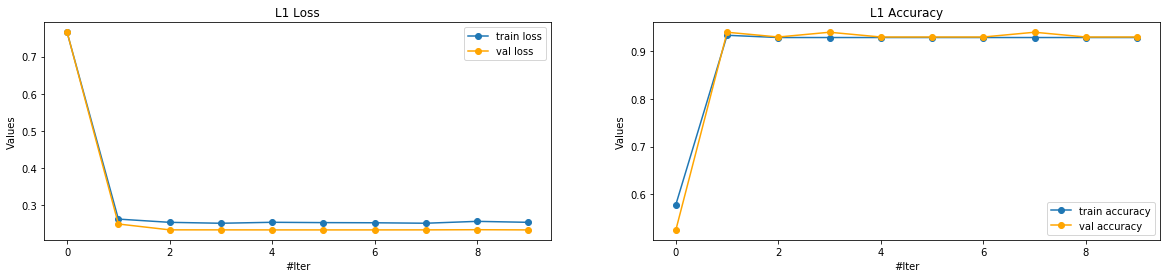

In [16]:
plot_plot(costs=costs_l1,acc_trains=acc_trains_l1,acc_vals=acc_vals_l1,val_costs=val_costs_l1,method="L1")

可以看到 validation data loss 有明显的改善.但是两者的正确率都下来了,这是没有办法的,因为解决过拟合实际上就是让模型从过拟合的方向向欠拟合的方向走.

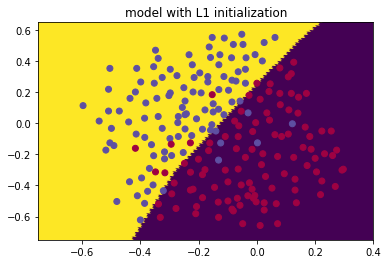

In [17]:
regular_model.plot_decision_boundary(X=train_X,Y=train_Y,paramerters=parameters_l1,title='L1')

很明显,决策边界也有了较大的改善.

现在尝试使用"L2"

#### L2 regulation 

In [20]:
layers = [20,3,1]
regular_model = Regular_Model(layers=layers,epochs=35000,lr=0.3,print_step=3500,is_print=True)

In [21]:
costs_l2,acc_trains_l2,acc_vals_l2,val_costs_l2,parameters_l2 = regular_model.fit(train_X,train_Y,test_X,
                                                                                  test_Y,lambd=0.5,
                                                                                  regularize_method='l2')

layers [2, 20, 3, 1]
[3500/35000] train loss:0.7128298776832899 - train acc:0.5781990521327014 - val loss:0.7106750527062986 - val acc:0.52
[7000/35000] train loss:0.2563883782037358 - train acc:0.933649289099526 - val loss:0.2678238719201391 - val acc:0.94
[10500/35000] train loss:0.25491744319921095 - train acc:0.933649289099526 - val loss:0.26875617944091273 - val acc:0.955
[14000/35000] train loss:0.254445452872066 - train acc:0.933649289099526 - val loss:0.2682617420349522 - val acc:0.955
[17500/35000] train loss:0.2541741089342292 - train acc:0.933649289099526 - val loss:0.2679692983550926 - val acc:0.955
[21000/35000] train loss:0.2535643007762538 - train acc:0.933649289099526 - val loss:0.26803205736432334 - val acc:0.955
[24500/35000] train loss:0.25389839970665823 - train acc:0.933649289099526 - val loss:0.2679038551815396 - val acc:0.955
[28000/35000] train loss:0.2539916849595511 - train acc:0.933649289099526 - val loss:0.26781511651512374 - val acc:0.955
[31500/35000] trai

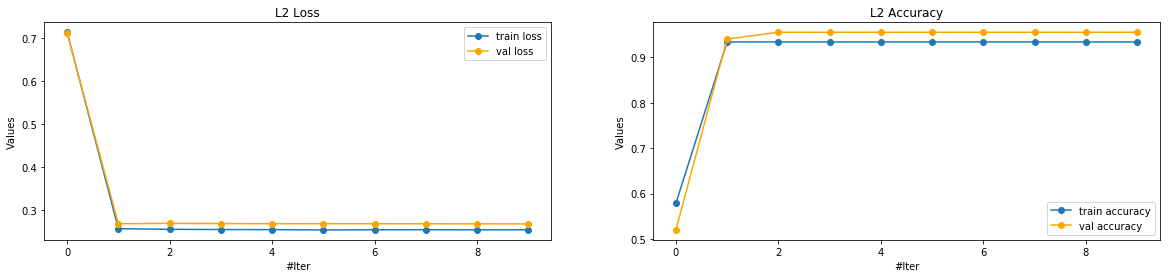

In [22]:
plot_plot(costs=costs_l2,acc_trains=acc_trains_l2,acc_vals=acc_vals_l2,val_costs=val_costs_l2,method="L2")

可以看到validation data loss也变得更加优秀,虽然整体正确率相比于Base Lines会低一点点,但是比"L1"更好,所以"L2"更常用.

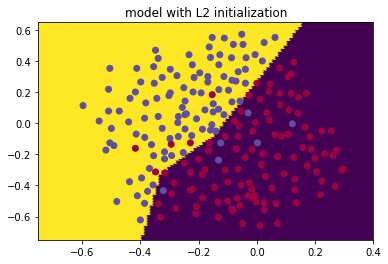

In [23]:
regular_model.plot_decision_boundary(X=train_X,Y=train_Y,paramerters=parameters_l2,title='L2')

很明显的可以看到"L2"的效果会比"L1"的弱一些,但是相对于Base Lines而言也得到很大的改善.

### 3.Dropout:

**Dropout做缩放处理:**

$P\sim Bernoulli(P)$

$\tilde{y}^{[l-1]}=P^{[l-1]}*y^{[l-1]}$

对$y^{[l]}$ 进行缩放

$\tilde{y}^{[l]} = \frac{\tilde{y}^{[l]}}{P}$

$Z^{[l]}=W^{[l]}\tilde{y}^{[l]}+b^{[l]}$

$y^{[l]}=Activate(Z^{[l]})$


**FP:**

$d^{[l]} = (np.random.rand(A^{[l]}.shape[0],A^{[l]}.shape[1]) < keep-pro)\;/\;keep-pro $

$A^{[l]} = np.multiply(A^{[l]},d^{[l]})$


这里的keep-pro为保留率,也就是说相当于$1-P$,比如keep-pro=0.8,说明80%的节点保留,删除20%.且和上面的算法是等价的.

**BP:**

$dA^{[l]} = np.multiply(dA^{[l]},d^{[l]})$


**Note:**

(1) Dropout 是对激活函数后的$y$值进行神经元关闭处理.

(2) Dropout 对于输入层和输出层是不做处理的且在测试阶段也不做处理,因为会导致模型的不稳定.

(3) 由于随机关闭一些神经元意味着$A$中大部分的值为0,那么在计算$loss$的时候就会出现问题,以Binary Cross Entropy而言,会计算log项,就会出现警告.其实也无伤大雅,因为loss只是一个衡量算法的一个学习过程,并不与算法整体运行相关.

**函数解释表:**

Dropout和普通的Base Lines不同的是Forward和Backward以及测试阶段的Forward.

[1]

```python
def forward(self,X,parameters,is_dropout=True):
    ...````
    
```if is_dropout:```用于判断是否需要Dropou,因为我们知道在测试阶段,我们是关闭Dropout的,如果在测试阶段不关闭,那么整体模型将会处于一种"不稳定状态".

在最后的输出层,我们不采用Dropout.

[2]

```python
def backward(self,A,y,parameters,cache):
    ...```

在方向传播的时候,我们需要注意:

在正向传播过程中我们关闭的哪些神经元节点,那么我们在反向传播的时候也需要关闭,所以我们需要将正向传播中的```cache['dropout_mask'+str(l+1)] = dropout_mask```保存,以用于反向传播```dA_dropout = np.multiply(dA,cache['dropout_mask'+str(l-1)]) ```.


In [33]:
class Dropout_Model:
    """ Build Dropout Model."""
    def __init__(self,layers,epochs,lr,print_step=100,is_print=False):
        """
        Initialization class
        
        Parameters:
        ----------
            layers: hidden layer's units,like [2,3,1],2: first hidden layer,3:second hidden layer 1:output layer.
            epochs: #Iterate 
            lr: Learning rate.
            print_step: print loss step.
            is_print: is print is ture,else not print loss.
        """
        self.layers = layers
        self.epochs = epochs
        self.print_step = print_step
        self.lr = lr
        self.is_print = is_print
        self.costs = []
        self.acc_trains = []
        self.val_costs = []
        self.acc_vals = []
    
    def init_parameters(self):
        """
        Initialization parameters.
        
        init weights and bias:
            weights shape: [input_features,output_features]
            bais shape: [1,output_features]
        """
        np.random.seed(1)
        self.L = len(self.layers)
        
        parameters = {}
        for l in range(self.L-1):
            W = np.random.randn(self.layers[l],self.layers[l+1]) / np.sqrt(self.layers[l])
            b = np.zeros((1,self.layers[l+1]))
            parameters['W' + str(l+1)] = W
            parameters['b' + str(l+1)] = b
            
        return parameters
    
    def relu(self,Z):
        """
        activation function ReLu.
        """
        return np.maximum(1e-10,Z)
    def sigmoid(self,Z):
        """
        activation function sigmoid.
        """
        return 1./(1.+np.exp(-Z))
    
    def loss(self,A,y):
        """
        caculate loss.
        Parameters:
        ----------
            A: output layers value.
            y: true labels. shape must be [m_sample/batch size,1].
        Return:
        ------
            J: loss value
            
        """
        m = y.shape[0]
        J = - np.nansum(np.add(np.multiply(y,np.log(A)),np.multiply((1-y),np.log(1-A))))/m
        return J
    
    def forward(self,X,parameters,is_dropout=True):
        """
        Forward Propagation.
        Parameters:
        ----------
            X: data set.
            parameters: include weights and bias.
            is_dropout:is dropout if True,else did not use it.
        Returns:
        -------
            A: output layer value.
            cache: include Z and A. using for backward propagation.
        """
        A = X
        cache = {'A0':A}
        for l in range(self.L-1):
            W = parameters['W' + str(l+1)]
            b = parameters['b' + str(l+1)]
            Z = np.dot(A,W) + b
            cache['Z'+str(l+1)] = Z
            if l != self.L-2:
                A = self.relu(Z)
                # is using dropout
                if is_dropout:
                    dropout_mask = (np.random.rand(*A.shape) < self.keep_prob) / self.keep_prob
                    A = np.multiply(A,dropout_mask)
                    # cache dropout_mask to use backward.
                    cache['dropout_mask'+str(l+1)] = dropout_mask
            else:
                A = self.sigmoid(Z)
            cache['A'+str(l+1)] = A
        return A,cache
    
    
    def backward(self,A,y,parameters,cache):
        """
        Backward Propagation.
        
        Parameters:
        ----------
            A: output layer value.
            y: true labels. shape must be [m_sample/batch size,1].
            parameters: include weights and bias.
            cache: include Z and A.
        Returns:
        -------
            d_parameters: include dW,db,dA,using for updating.
        """
        m = y.shape[0]
        d_parameters ={}
        
        for l in range(self.L-1,0,-1):
            if l == self.L-1:
                d_parameters['dZ'+str(l)] = np.subtract(cache['A'+str(l)],y)
            else:
                d_parameters['dZ'+str(l)] = np.multiply(d_parameters['dA'+str(l)],np.int64(cache['Z'+str(l)] > 0))

            d_parameters['dW'+str(l)] = np.dot(cache['A'+str(l-1)].T,d_parameters['dZ'+str(l)])/m 
            d_parameters['db'+str(l)] = np.sum(d_parameters['dZ'+str(l)],axis=0,keepdims=True)/m
            if l != 1:
                dA = np.dot(d_parameters['dZ'+str(l)],parameters['W'+str(l)].T)
                # multiply dropout result, if use it.
                dA_dropout = np.multiply(dA,cache['dropout_mask'+str(l-1)]) 
                d_parameters['dA'+str(l-1)] = dA_dropout # cache dA to caculate dW.

        return d_parameters
    
    def update(self,parameters,dparameters):
        """
        Update parameters.
        
        Parameters:
        ----------
           parameters: include weights and bias.
           dparameters : include derivative weights and derivative bias.
           
        Return:
        ------
            parameters: updated parameters.
        """
        for l in range(self.L-1):
            parameters['W'+str(l+1)] -=  self.lr * dparameters['dW'+str(l+1)]
            parameters['b'+str(l+1)] -=  self.lr * dparameters['db'+str(l+1)]
        return parameters
    
    
    
    def fit(self,data,labels,val_data,val_labels,keep_prob):
        """
        Fitting Model.
        
        ##################################################################################################
        # 0.initialization keep_prob.it's a keep probability,not delete probability                      #                                                                   
        # 1.reshape train/val labels, shape like [m_sample,1].                                           #
        # 2.add inpute layer features to layers,so layers like [input units,hidden units,output units].  #
        # 3.Initialization parameters.                                                                   #  
        # 4. start training model.                                                                       #      
        # 5. each sel.print_step to print loss and add accuracy/ val loss.                               #
        # 6. returns something.                                                                          #
        ##################################################################################################
        
        Parameters:
        ----------
            data: training data set.
            labels: training labels.
            val_data: validation data set.
            val_labels: validation labels.
        Returns:
        -------
            self.costs: loss value of each self.print.
            self.acc_trains: training data accuracy of each self.print.
            self.acc_vals: validation accuracy of each self.print.
            self.val_costs: validation loss value of each self.print.
        """
        self.keep_prob = keep_prob
        labels = labels.reshape(-1,1)
        val_labels = val_labels.reshape(-1,1)
        m,n = data.shape
        self.layers.insert(0,n)
        print("layers",self.layers)
        self.L = len(self.layers)
        parameters = self.init_parameters()
        
        # start training model
        for epoch in range(self.epochs):
            
            # start forward
            A,cache = self.forward(X = data,parameters=parameters)
            # start caculate loss
            loss = self.loss(A,labels)
            # start backward
            d_parameters = self.backward(A,labels,parameters,cache)
            # start updating
            parameters = self.update(parameters=parameters,dparameters=d_parameters)
            # print loss of each print step.
            if epoch % self.print_step == 0 and self.is_print:
                    acc_train = self.score(data,labels,parameters)
                    acc_val,val_loss = self.score(val_data,val_labels,parameters,is_loss=True)
                    print('[{}/{}] train loss:{} - train acc:{} - val loss:{} - val acc:{}'.format(epoch,
                                                                                                  self.epochs,
                                                                                                  loss,
                                                                                                  acc_train,
                                                                                                  val_loss,
                                                                                                  acc_val))
                    self.costs.append(loss)
                    self.acc_trains.append(acc_train)
                    self.acc_vals.append(acc_val)
                    self.val_costs.append(val_loss)
                
        return self.costs,self.acc_trains,self.acc_vals,self.val_costs,parameters
        
            
    def score(self,X,y,parameters,is_loss=False):
        """
        Score model.
        Parameters:
        ----------
            X: score data set.
            y: score data labels.
            parameters:include best weigts and bias.
            is_loss:  calculate X's loss if ture,generally calculate validation data loss.
        Returns:
        -------
            acc: correct rate.
            loss: loss value if caculate.
        """
        m = y.shape[0]
        A,_ = self.forward(X=X,parameters=parameters,is_dropout=False)
        predict = np.round(A)
        acc = (np.equal(predict,y)).sum() / m
        if is_loss:
            loss = self.loss(A,y)
            return acc,loss    
        else:
            return acc
        
    def plot_decision_boundary(self,X,Y,paramerters,title):
        """
        Plot decision boundary.
        
        Parameters:
        ----------
            X: data set.
            Y: data labels.
            paramerters: best parameters.
            title: figure title.
        """

        x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
        y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1

        x = np.arange(x_min,x_max,0.01)
        y = np.arange(y_min,y_max,0.01)
        xx,yy = np.meshgrid(x,y)

        X_ = np.c_[xx.ravel(),yy.ravel()]
        
        A,_ = self.forward(X=X_,parameters=paramerters,is_dropout=False)
        y_hat = np.round(A)
        
        fig = plt.figure()
        plt.subplot(1,1,1)
        plt.xlim([-0.75,0.40])  # Set the x-axis range
        plt.ylim([-0.75,0.65])
        plt.title('model with {} initialization'.format(title))
        plt.scatter(X_[:,0], X_[:,1], c=np.squeeze(y_hat))
        plt.scatter(X[:,0], X[:,1], c=np.squeeze(Y), cmap=plt.cm.Spectral,linewidths=1)

In [34]:
layers = [20,3,1]
dropout_model = Dropout_Model(layers=layers,epochs=35000,lr=0.3,print_step=3500,is_print=True)

In [35]:
costs_dp,acc_trains_dp,acc_vals_dp,val_costs_dp,parameters_dp = dropout_model.fit(train_X,
                                                                               train_Y,test_X,test_Y,keep_prob=0.7)

layers [2, 20, 3, 1]
[0/35000] train loss:0.694478433053622 - train acc:0.6161137440758294 - val loss:0.6841954506527123 - val acc:0.545


/Users/huwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/Users/huwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in multiply


[3500/35000] train loss:0.3267355306618203 - train acc:0.9478672985781991 - val loss:0.2833208503711977 - val acc:0.945
[7000/35000] train loss:0.27698740321024 - train acc:0.933649289099526 - val loss:0.3725363636116403 - val acc:0.935
[10500/35000] train loss:0.30380232413448666 - train acc:0.943127962085308 - val loss:inf - val acc:0.94
[14000/35000] train loss:0.2205177348339679 - train acc:0.943127962085308 - val loss:inf - val acc:0.935
[17500/35000] train loss:0.23827526114839842 - train acc:0.933649289099526 - val loss:inf - val acc:0.93
[21000/35000] train loss:0.24451648957207095 - train acc:0.9383886255924171 - val loss:inf - val acc:0.93
[24500/35000] train loss:0.26459581621153755 - train acc:0.9383886255924171 - val loss:inf - val acc:0.935
[28000/35000] train loss:0.2753984308000269 - train acc:0.933649289099526 - val loss:inf - val acc:0.93
[31500/35000] train loss:0.24538818361781123 - train acc:0.943127962085308 - val loss:inf - val acc:0.935


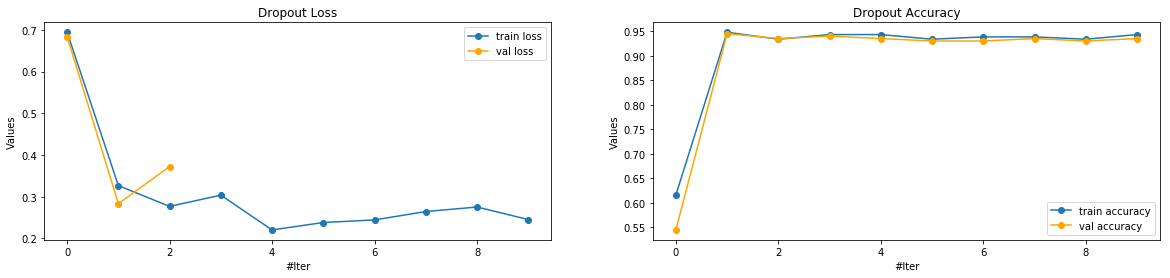

In [36]:
plot_plot(costs=costs_dp,acc_trains=acc_trains_dp,acc_vals=acc_vals_dp,val_costs=val_costs_dp,method="Dropout")

可以看到loss值在2个epoch的时候消失了,是因为log的值为0,这一点是无伤大雅的.

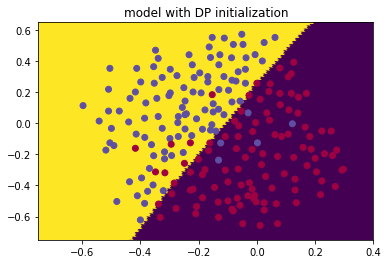

In [37]:
dropout_model.plot_decision_boundary(X=train_X,Y=train_Y,paramerters=parameters_dp,title='DP')

可以看到大杀器Dropout的效果也是很厉害的,通过控制不同的keep-prob来解决过拟合,实际上随着网络的深度增加,Dropout的效果会愈发明显,另外现阶段还有比较流行的是Batch Normal和MS.

### Summary:

(1) 除非模型发生过拟合,否则没必要使用以上操作.

(2) 对于Dropout而言,有好处也有坏处

(2.1) 当前Dropout被大量利用于全连接网络,而且一般认为设置为0.5或者0.3,而在卷积网络隐藏层中由于卷积自身的稀疏化以及稀疏化的ReLu函数的大量使用等原因,Dropout策略在卷积网络隐藏层中使用较少.总体而言,Dropout是一个超参,需要根据具体的网络,具体的应用领域进行尝试.

(2.2)实施dropout在computer vision 上应用广泛,因为CV上的输入量非常大,但是在其他领域就相对较少.并且如果是针对于卷积操作那么由于卷积本身就是在做稀疏处理,所以很少会加Dropout.

(2.3) 除非算法过拟合,否则尽量不要使用正则化

(2.4)dropout的一大缺点就是代价函数J不能再被明确定义(因为神经元随机删除),最起码是很难去定义,所以我们通常会关闭dropout函数,keep-prob = 1,来绘制cost function.也就是说在输出层我们不会采取Dropout.

(2.5)dropout缺点:

- 需要使用交叉验证,你要搜索更多的超级参数(因为神经单元有变化)